In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.stats import gaussian_kde

import torch
from torchmetrics.functional import spearman_corrcoef as spearman
from data import get_data

from intensity import get_intensities
from get_ssims import get_ssims
device = torch.device('cuda:7')

# Set Panel

In [4]:
#correlation based panels from Ternes et. al. 23
ternes_corr_panels = [[0, 22, 7],
                     [0, 4, 5, 8, 22, 23],
                     [0, 4, 5, 8, 10, 12, 18, 22, 23],
                     [0, 3, 4, 5, 10, 12, 14, 15, 18, 22, 23, 24],
                     [0, 1, 2, 3, 4, 5, 6, 10, 12, 14, 15, 18, 22, 23, 24],
                     [0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 18, 20, 22, 23, 24] 
                    ]

In [5]:
ch2stain = {0:"DAPI", 1:"CD3", 2:"ERK-1", 3:"hRAD51", 4:"CyclinD1", 5:"VIM", 6:"aSMA", 7:"ECad", 8:"ER", 9:"PR",
            10:"EGFR", 11:"Rb", 12:"HER2", 13:"Ki67", 14:"CD45", 15:"p21", 16:"CK14", 17:"CK19", 18:"CK17",
            19:"LaminABC", 20:"AR", 21:"Histone H2AX", 22:"PCNA", 23:"PanCK", 24:"CD31"}

# Get Model Checkpoints and Panel Selection Orders

In [6]:
ckpt_25p = 'ckpts/BC_TMA_25p_mask_cls_epoch=499-step=76500-v2.ckpt'
ckpt_50p = 'ckpts/50p_mask_12l_dec.ckpt' #BC
panel_order_50p = [0,10,17,6,14,13,18,3,24,2,21,4,12,1,9,11,15,7,20,5,19,22,8,23] #see iterative panel selection notebook
ckpt_75p = 'ckpts/75p_mask_12l_dec_499e.ckpt'
panel_order_75p = [0, 16, 5, 8, 9, 22, 1, 24, 6, 18, 11, 2, 15, 13, 17, 12, 20, 10]

In [7]:
panel_order_50p = [0,7,16,12,14,9,18,22,24,1,11,6,2,15,23,13,21,5,3,4,20,8,19,17]

# Load Models

In [8]:
from mae import IF_MAE
model_25p = IF_MAE().load_from_checkpoint(ckpt_25p)
model_25p = model_25p.to(device)
model_25p = model_25p.eval()
model_50p = IF_MAE().load_from_checkpoint(ckpt_50p)
model_50p = model_50p.to(device)
model_50p = model_50p.eval()
model_75p = IF_MAE().load_from_checkpoint(ckpt_75p)
model_75p = model_75p.to(device)
model_75p = model_75p.eval()

# Load Data

In [9]:
val_loader = get_data('BC', 10000)

# Run Model to get Mean Intensities and SSIMs

In [10]:
ssims_corr, intensities_corr = [],[]

for model in [model_25p, model_50p, model_75p]:
    intensities_, ssims_ = [], []
    
    for panel in ternes_corr_panels:
        unmasked_ch_idx = panel
        mints, pmints = get_intensities(model, unmasked_ch_idx, val_loader, device=device)
        #ssims_.append(get_ssims(model, unmasked_ch_idx, val_loader, device=device))
        intensities_.append((mints, pmints))
        
    ssims_corr.append(ssims_)
    intensities_corr.append(intensities_)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.68s/it]


In [11]:
ssims_iter, intensities_iter = [],[]
for model,panel_order in zip([model_50p, model_75p], [panel_order_50p, panel_order_75p]):
    intensities_, ssims_ = [], []
    panel_sizes = [s for s in range(1,25)]
    
    for panel_size in panel_sizes:
        unmasked_ch_idx = panel_order[:panel_size]
        mints, pmints = get_intensities(model, unmasked_ch_idx, val_loader, device=device)
        #ssims_.append(get_ssims(model, unmasked_ch_idx, val_loader, device=device))
        intensities_.append((mints, pmints))
        
    ssims_iter.append(ssims_)
    intensities_iter.append(intensities_)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.68s/it]


# Plot Mean Intensities for Each Panel 

In [12]:
def get_corrs(mints, pmints):
    if mints.shape[1] == 1:
        stain_corrs = spearman(pmints.squeeze(), mints.squeeze())
        stain_corrs = stain_corrs.unsqueeze(0)
    else:
        stain_corrs = spearman(pmints, mints)
    return stain_corrs

In [13]:
stain_corrs_per_ratio = []
for intensities_ in intensities_corr:
    stain_corrs = []
    for mints_, pmints_ in intensities_:
        stain_corrs.append(get_corrs(mints_, pmints_))
    stain_corrs_per_ratio.append(stain_corrs)

In [14]:
stain_corrs_per_ratio_iter = []
for intensities_ in intensities_iter:
    stain_corrs = []
    for mints_, pmints_ in intensities_:
        stain_corrs.append(get_corrs(mints_, pmints_))
    stain_corrs_per_ratio_iter.append(stain_corrs)

In [15]:
stain_corrs_per_ratio = [[s.detach().cpu().numpy() for s in stain_corrs] 
                         for stain_corrs in stain_corrs_per_ratio]

In [16]:
stain_corrs_per_ratio_iter = [[s.detach().cpu().numpy() for s in stain_corrs] 
                         for stain_corrs in stain_corrs_per_ratio_iter]

In [17]:
corr_sets_corr = stain_corrs_per_ratio[1]

In [18]:
corr_sets_iter = stain_corrs_per_ratio_iter[0]

In [19]:
corr_sets_iter = [corr_sets_iter[3], corr_sets_iter[6], corr_sets_iter[9], corr_sets_iter[12], corr_sets_iter[15], corr_sets_iter[18]]

In [20]:
all_corrs = []
for corr_1, corr_2 in zip(corr_sets_corr, corr_sets_iter):
    all_corrs.append(corr_1)
    all_corrs.append(corr_2)

In [23]:
corr_sets_iter[2].mean()

0.9279927

In [24]:
corr_sets_corr[2].mean()

0.91450536

In [ ]:
69.9
91.5
92.8

In [25]:
91.5 - 69.9

21.599999999999994

In [26]:
92.8 - 91.5

1.2999999999999972

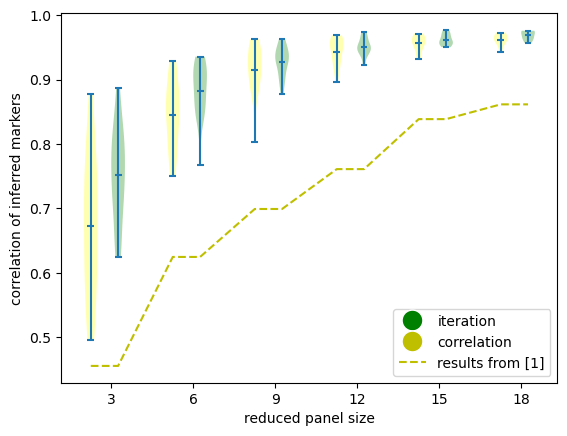

In [21]:
positions = [0.5,1.5,
             3.5,4.5,
             6.5,7.5,
             9.5,10.5,
             12.5,13.5,
             15.5,16.5]
bplot = plt.violinplot(all_corrs,positions=positions,showmeans=True)
plt.xticks([1.25,4.25,7.25,10.25,13.25,16.25],['3','6','9','12','15','18'])
plt.xlabel('reduced panel size')
plt.ylabel('correlation of inferred markers')
#plt.title('Comparative Performance of Panel Selection Strategies')
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='g', markersize=15),
                 Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='y', markersize=15),
                 Line2D([0], [0], ls='--', color='y', label='Scatter')]
plt.legend(custom_points, ['iteration','correlation','results from [1]'],loc='lower right')
for i,patch in enumerate(bplot['bodies']):
    if i % 2 == 0:
        patch.set_facecolor('yellow')
    elif i % 2 == 1:
        patch.set_facecolor('green')
CorrVec=  [0.45542308872608434,0.45542308872608434,
           0.6246306319916533,0.6246306319916533,
           0.6990946473098055,0.6990946473098055,
           0.7609945744264635,0.7609945744264635,
           0.8386137549988064, 0.8386137549988064,
           0.861531529832696,0.861531529832696]
plt.plot(positions,CorrVec,ls='--',c='y')
plt.savefig('plots/compare_strategies.svg')
plt.show()

In [20]:
mean_corrs_25p = [np.mean(corrs) for corrs in stain_corrs_per_ratio[0]]
mean_corrs_50p = [np.mean(corrs) for corrs in stain_corrs_per_ratio[1]]
mean_corrs_75p = [np.mean(corrs) for corrs in stain_corrs_per_ratio[2]]

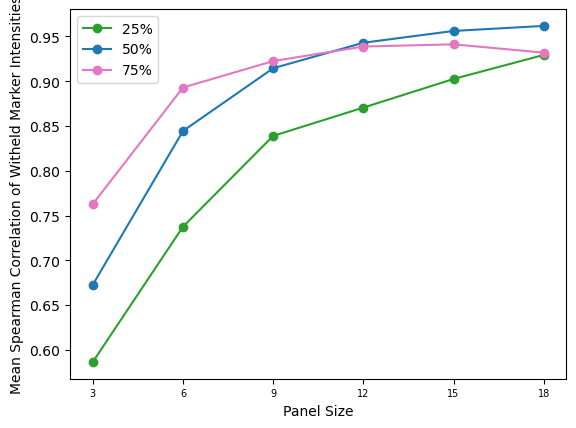

In [21]:
fig, ax = plt.subplots()
ax.plot(np.arange(6), mean_corrs_25p, marker='o', color='tab:green')
ax.plot(np.arange(6), mean_corrs_50p, marker='o', color='tab:blue')
ax.plot(np.arange(6), mean_corrs_75p, marker='o', color='tab:pink')
ax.set_xticks(np.arange(6), [3,6,9,12,15,18], fontsize=7)
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker='o', color='tab:green', label='Scatter'),
                 Line2D([0], [0], marker='o', color='tab:blue', label='Scatter'),
                 Line2D([0], [0], marker='o', color='tab:pink', label='Scatter')]
plt.legend(custom_points, ['25%', '50%', '75%'],loc='upper left')
plt.xlabel('Panel Size')
plt.ylabel('Mean Spearman Correlation of Witheld Marker Intensities')
#plt.title('Influence of Masking Ratio on Overall Prediction (BC)')
plt.show()